Notebook for generating figures for presentation slides.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import numpy as np
import torch
import torch.distributions as dists

import kcgof
import kcgof.log as klog
import kcgof.util as util
import kcgof.cdensity as cden
import kcgof.cdata as cdat
import kcgof.cgoftest as cgof
import kcgof.kernel as ker
import kcgof.plot as plot

import scipy.stats as stats

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 20
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Plot the conditional Stein witness function

$$ g(w|x)$$

In [20]:
def get_rhet_plin_problem(n=400, seed=20):
    """
    r (true distribution) is heteroscedastic. p (model) is linear.
    """
    g_het_center = torch.tensor([2.0])
    g_het_spike_var = 16
    dx = 1
    
    # p(y|x)
    pslope = torch.tensor([1.0])
    f_quad = lambda X: (X**2).sum(dim=1)
#     p = cden.CDGaussianOLS(slope=pslope, c=0.0, variance=1.0)
    p = cden.CDAdditiveNoiseRegression(
        f = f_quad,
        noise=dists.Normal(0, 1), dx=1,
    )
    
    # rx
    rx = dists.Normal(1, 1.0)    
#     rx = dists.Uniform(-1, 1)
    # r(y|x)
    cs = cdat.CSGaussianHetero(
#         f=lambda X: X.sum(dim=1),
        f=f_quad,
        f_variance= lambda X: 1.0 
            + g_het_spike_var*torch.exp( -0.5*torch.sum( (X -
            g_het_center)**2, dim=1 )/0.05**2 ),
#         f_variance=lambda X: torch.ones(X.shape[0]),
        dx=dx)
#     cs = cdat.CSGaussianOLS(slope=pslope, c=0.0, variance=1.0)
    
    # sample Y conditioned on X
    with util.TorchSeedContext(seed=seed):
        X = rx.sample((n, dx))
    Y = cs(X, seed=seed+77)
    return p, cs, rx, X, Y
    

In [21]:
p, cs, rx, X, Y = get_rhet_plin_problem(n=400, seed=9)

In [22]:
# k = kernel on X
k = ker.PTKGauss(sigma2=0.1)

# l = kernel on Y
l = ker.PTKGauss(sigma2=1.0)

In [23]:
ep = 1.0
n_grid_points = 100
# make a grid that covers X

domX = torch.linspace(torch.min(X)-ep, torch.max(X)+ep, n_grid_points)
domY = torch.linspace(torch.min(Y).item()-ep, torch.max(Y).item()+ep, n_grid_points)

fscd_pc = cgof.FSCDPowerCriterion(p, k, l, X, Y)

# evaluate the power criterion function
wit_values = fscd_pc.eval_witness(at=domX.unsqueeze(1))
pow_cri_values = fscd_pc.eval_power_criterion(at=domX.unsqueeze(1).unsqueeze(1))

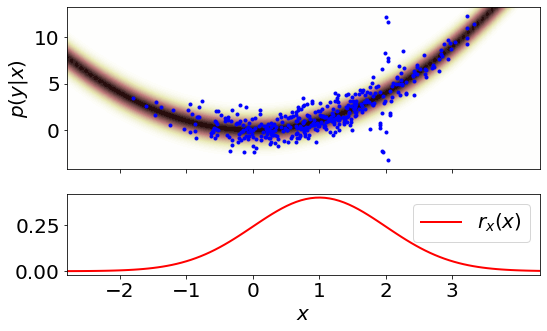

In [26]:
fig, axes = plot.plot_2d_cond_model(
    p, 
    lambda X: torch.exp(rx.log_prob(X)), 
    X, Y, domX=domX, domY=domY, 
    height_ratios=[2,1],
    cmap='pink_r', levels=50)

fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
xticks_range = np.arange(-2, 3+1)
axes[0].set_xticks(xticks_range);
plt.legend()
plt.savefig('present/quad_toy.pdf', bbox_inches='tight')
# plt.xlabel('$x$')
# plot.plot_2d_cond_data(X, Y)

Plot the conditional Stein witness $g_{p,r}(w|x)$ function. Not smoothed with `K` yet. 
Plotting this function requires `cheating` i.e., for each x, we need to sample $y | x \sim r(y|x)$.

In [9]:
def cond_stein_wit(X, Y, p, cs, l, n_sample, seed=28):
    """
    Evaluate the Stein witness at (Y, X). This requires sampling from the 
    true distribution r(y|x) through `cs`. Sample `n_sample` times, for each x.
    
    ** Assume that dy=1.
    
    Return a Torch tensor of length n, where n = X.shape[0] = Y.shape[0]
    """
    if Y.shape[1] != 1:
        raise ValueError('This function can only handle dy=1. Found dy={}'.format(Y.shape[1]))
#     kcsd = cgof.KCSDTest(p, k, l)
    n = X.shape[0]

    gyx = torch.zeros(n)
    for i in range(n):
        xi = X[[i]]

        # sample Y | xi
        xirep = xi.repeat(n_sample, 1)
        Yi = cs(xirep, seed=seed)
        # n_sample x 1
        pgl = p.grad_log(xirep, Yi)

        yi = Y[[i]]
        # n_sample x 1
        grad_yi = l.gradX_Y(Yi, yi, dim=0)
        Lyi = l.eval(Yi, yi)
        Xi = Lyi*pgl + grad_yi
        gyx[i] = Xi.mean()
    return gyx
    

In [10]:
n_sample = 1000
mdomY, mdomX = torch.meshgrid(domY.view(-1), domX.view(-1))
flat_gyx = cond_stein_wit(mdomX.reshape(-1, 1), mdomY.reshape(-1, 1), 
                          p, cs, l, n_sample=n_sample)

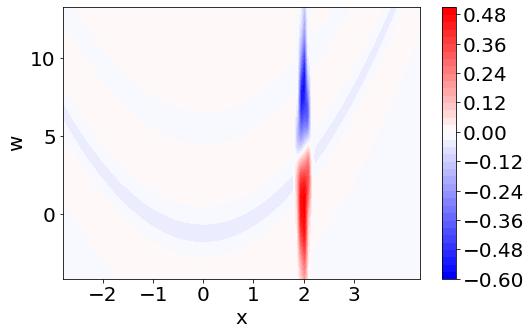

In [79]:
Gyx = flat_gyx.view(mdomX.shape)

np_mdomX = mdomX.detach().numpy()
np_mdomY = mdomY.detach().numpy()
np_Gyx = Gyx.detach().numpy()

elev_min=np.min(np_Gyx) 
elev_max=np.max(np_Gyx) 
mid_val=0

# set the colormap and centre the colorbar
# https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
import matplotlib.colors as colors
from matplotlib import colors
color_norm = colors.DivergingNorm(vmin=elev_min, vcenter=0., vmax=elev_max)

# contour plot
plt.figure(figsize=(8, 5))

plt.contourf(np_mdomX, np_mdomY, np_Gyx, levels=40, 
#              clim=(elev_min, elev_max), 
             norm=color_norm,
             cmap='bwr',
            )
plt.xlabel('x')
plt.ylabel('w')
plt.xticks(xticks_range)
plt.colorbar()
plt.savefig('present/cond_stein_wit.pdf', bbox_inches='tight')

Same figure plotted as a 3d surface

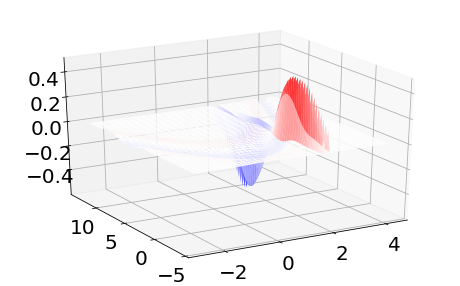

In [93]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')


# make the panes transparent
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Plot the surface.
ax.view_init(25, 240)
surf = ax.plot_surface(np_mdomX, np_mdomY, np_Gyx,
                       linewidth=0, antialiased=True, norm=color_norm,
                      cmap='bwr')

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
fig.savefig('present/cond_stein_wit_3d.pdf', bbox_inches='tight')

Now plot the witness function of KCSD. Still a function of both (x,y).

In [12]:
def kcsd_wit(X, Y, Xrep, Yrep, p, k, l):
    """    
    Return a Torch tensor of length n, where n = X.shape[0] = Y.shape[0]
    - X, Y: points to evaluate the witness
    - Xrep, Yrep: points used to represent the witness. May require a large sample.
    """
    if Y.shape[1] != 1:
        raise ValueError('This function can only handle dy=1. Found dy={}'.format(Y.shape[1]))

    n = X.shape[0]
    
    gyx = torch.zeros(n)

    pgl = p.grad_log(Xrep, Yrep)
    Lrep = l.eval(Yrep, Y)
    Lgrad = l.gradX_Y(Yrep, Y, dim=0)
    Krep = k.eval(Xrep, X)

    S = Krep*(pgl*Lrep + Lgrad)
    return S.mean(0)

In [13]:
p, cs, rx, X, Y = get_rhet_plin_problem(n=20000, seed=9)
# k = kernel on X
k = ker.PTKGauss(sigma2=0.15)

flat_kcsd_wit = kcsd_wit(mdomX.reshape(-1, 1), mdomY.reshape(-1, 1), Xrep=X, Yrep=Y, p=p, k=k, l=l)
Kwit = flat_kcsd_wit.view(mdomX.shape)

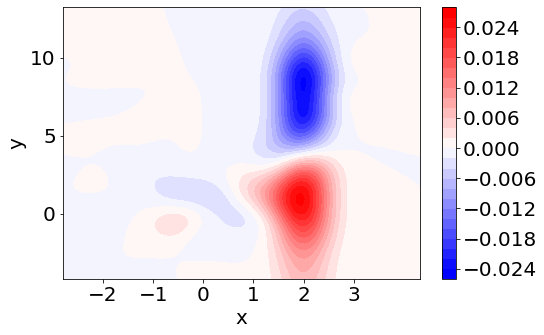

In [14]:
np_Kwit = Kwit.detach().numpy()
elev_min=np.min(np_Kwit) 
elev_max=np.max(np_Kwit) 
mid_val=0

# set the colormap and centre the colorbar
# https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
import matplotlib.colors as colors
from matplotlib import colors
color_norm = colors.DivergingNorm(vmin=elev_min, vcenter=0., vmax=elev_max)

# contour plot
plt.figure(figsize=(8, 5))

plt.contourf(np_mdomX, np_mdomY, np_Kwit, levels=30, 
#              clim=(elev_min, elev_max), 
             norm=color_norm,
             cmap='bwr',
            )
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(xticks_range)
plt.colorbar()

FSCD witness function. This is different from the KCSD witness above. 
The FSCD witness is only a function of x.

In [15]:
domX = torch.linspace(torch.min(X)-ep, torch.max(X)+ep, 300)
p, cs, rx, X, Y = get_rhet_plin_problem(n=4000, seed=8)
fscd_pc = cgof.FSCDPowerCriterion(p, k, l, X=X, Y=Y)
fscd_wit = fscd_pc.eval_witness(at=domX.reshape(-1, 1))

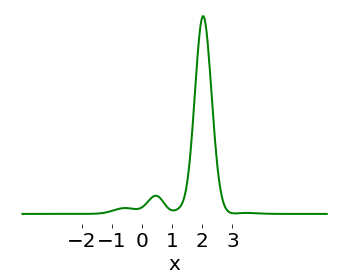

In [16]:
# plot the Fscd witness
np_domX = domX.detach().numpy()
np_fscd_wit = fscd_wit.detach().numpy()
plt.plot(np_domX, np_fscd_wit, 'g-')
plt.xlabel('x')
plt.xticks(xticks_range)
plt.box(False)
ax = plt.gca()
ax.get_yaxis().set_visible(False)